# Train a SNN obeying Dale's Law on the SHD dataset

In this notebook, we demonstrate the training of a 1-hidden-layer SNN obeying Dale's law on the [SHD dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/).

We will introduce the `DalianLayer` class from the `layer` module, and use the `FluctuationDrivenExponentialInitializer` class from the `initializer` module to initialize the Dalian network in the flucutation-driven regime.

In [37]:
# First, imports
import os
import sys

sys.path.append("../../stork-1")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change the default color cycle
np.random.seed(20250129)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=np.random.permutation(cm.batlow(np.linspace(0, 1, 10)))
)

import stork.datasets
from stork.datasets import (
    HDF5Dataset,
    DatasetView,
    make_tempo_randman,
    split_dataset,
    RasDataset,
)

from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, ExcInhLIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenExponentialInitializer, DistInitializer
from stork.layers import DalianLayer
from stork.activations import CustomSpike
from stork.loss_stacks import SumOfSoftmaxCrossEntropy
from stork.plotting_new import ActivityPlotter, plot_training

from scipy.stats import linregress

## Generate Dataset

#### Specifying dataset parameters

In [38]:
dim_manifold = 1
nb_classes = 10
nb_inputs = 20
nb_time_steps = 100
step_frac = 0.5
nb_samples = 1000
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt

In [39]:
data, labels = make_tempo_randman(
    dim_manifold=dim_manifold,
    nb_classes=nb_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=step_frac,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
)

In [40]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=True)
]
ds_train, ds_valid, ds_test = datasets

In [41]:
print(len(ds_train), len(ds_valid), len(ds_test))

8000 1000 1000


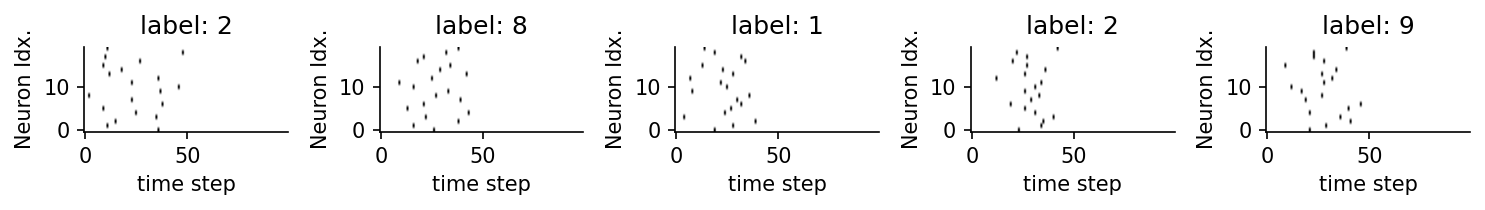

In [42]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [62]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_hidden_layers = 1
nb_exc_neurons = 80  # Number of excitatory neurons in the hidden layer
ei_ratio = 4  # Number of inhibitory neurons = nb_exc_neurons / ei_ratio

# Neuron Parameters
# # # # # # # # # # #
neuron_group = ExcInhLIFGroup

exc_neuron_kwargs = {"tau_mem": 20e-3, "tau_exc": 10e-3, "tau_inh": 20e-3}
inh_neuron_kwargs = {"tau_mem": 20e-3, "tau_exc": 10e-3, "tau_inh": 20e-3}
tau_readout = duration

# Training parameters
# # # # # # # # # # #

batch_size = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
lr = 5e-3
nb_epochs = 200

#### SuperSpike and loss function setup

In [63]:
act_fn = CustomSpike
act_fn.escape_noise_type = "sigmoid"
act_fn.escape_noise_params = {"beta": beta}

act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

loss_stack = SumOfSoftmaxCrossEntropy()

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

#### Optimizer setup

In [64]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=4)

In [65]:
# Define regularizer parameters (set regularizer strenght to 0 if you don't want to use them)
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    2  # Regularizes spikecount: 2 spike ~ 10 Hz in 200ms simulation time
)


# Define regularizer list
regs = []

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=-1
)
regs.append(regUB)

#### Initializer setup
We initialize in the fluctuation-driven regime with a target membrane potential standard deviation $\sigma_U=1.0$. Additionally, we set the proportion of membrane potential fluctuations driven by feed-forward inputs to $\alpha=0.9$.

In [66]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenExponentialInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt, alpha=0.9
)

readout_initializer = DistInitializer(
    dist=torch.distributions.Normal(0, 1), scaling="1/sqrt(k)"
)

#### Assemble the model

In [67]:
model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)
# INPUT LAYER
# # # # # # # # # # # # # # #
input_group = model.add_group(InputGroup(nb_inputs))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYER
# # # # # # # # # # # # # # #

layer = DalianLayer(
    name="Hid. 1",
    model=model,
    size=nb_exc_neurons,
    ei_ratio=ei_ratio,
    input_group=upstream_group,
    recurrent=True,
    neuron_class=neuron_group,
    exc_neuron_kwargs=exc_neuron_kwargs,
    inh_neuron_kwargs=inh_neuron_kwargs,
    regs=regs,
)

# Initialize Parameters
initializer.initialize(layer)

# Set output as input to next layer
upstream_group = layer.output_group

# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=10e-3, initial_state=-1e-3)
)

readout_connection = model.add_connection(
    Connection(upstream_group, readout_group, flatten_input=True)
)

# Initialize readout connection
readout_initializer.initialize(readout_connection)

#### Configure model for training

In [68]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

## Monitoring activity before training

In [69]:
for i, g in enumerate(model.groups[1:-1]):
    model.add_monitor(stork.monitors.StateMonitor(g, "syne", name="syne"))
    model.add_monitor(stork.monitors.StateMonitor(g, "syni", name="syni"))
    model.add_monitor(
        stork.monitors.PreciseBalanceMonitor(thr=None, group=g, name="precise_balance")
    )
    model.add_monitor(
        stork.monitors.DetailedBalanceMonitor(group=g, name="detailed_balance")
    )
    model.add_monitor(stork.monitors.TightBalanceMonitor(group=g, name="tight_balance"))
    model.add_monitor(
        stork.monitors.GlobalBalanceMonitor(group=g, name="global_balance")
    )

In [70]:
for mon in model.monitors:
    print(mon.name, mon.group.name)

syne Hid. 1 exc
syni Hid. 1 exc
precise_balance Hid. 1 exc
detailed_balance Hid. 1 exc
tight_balance Hid. 1 exc
global_balance Hid. 1 exc
syne Hid. 1 inh
syni Hid. 1 inh
precise_balance Hid. 1 inh
detailed_balance Hid. 1 inh
tight_balance Hid. 1 inh
global_balance Hid. 1 inh


plotting


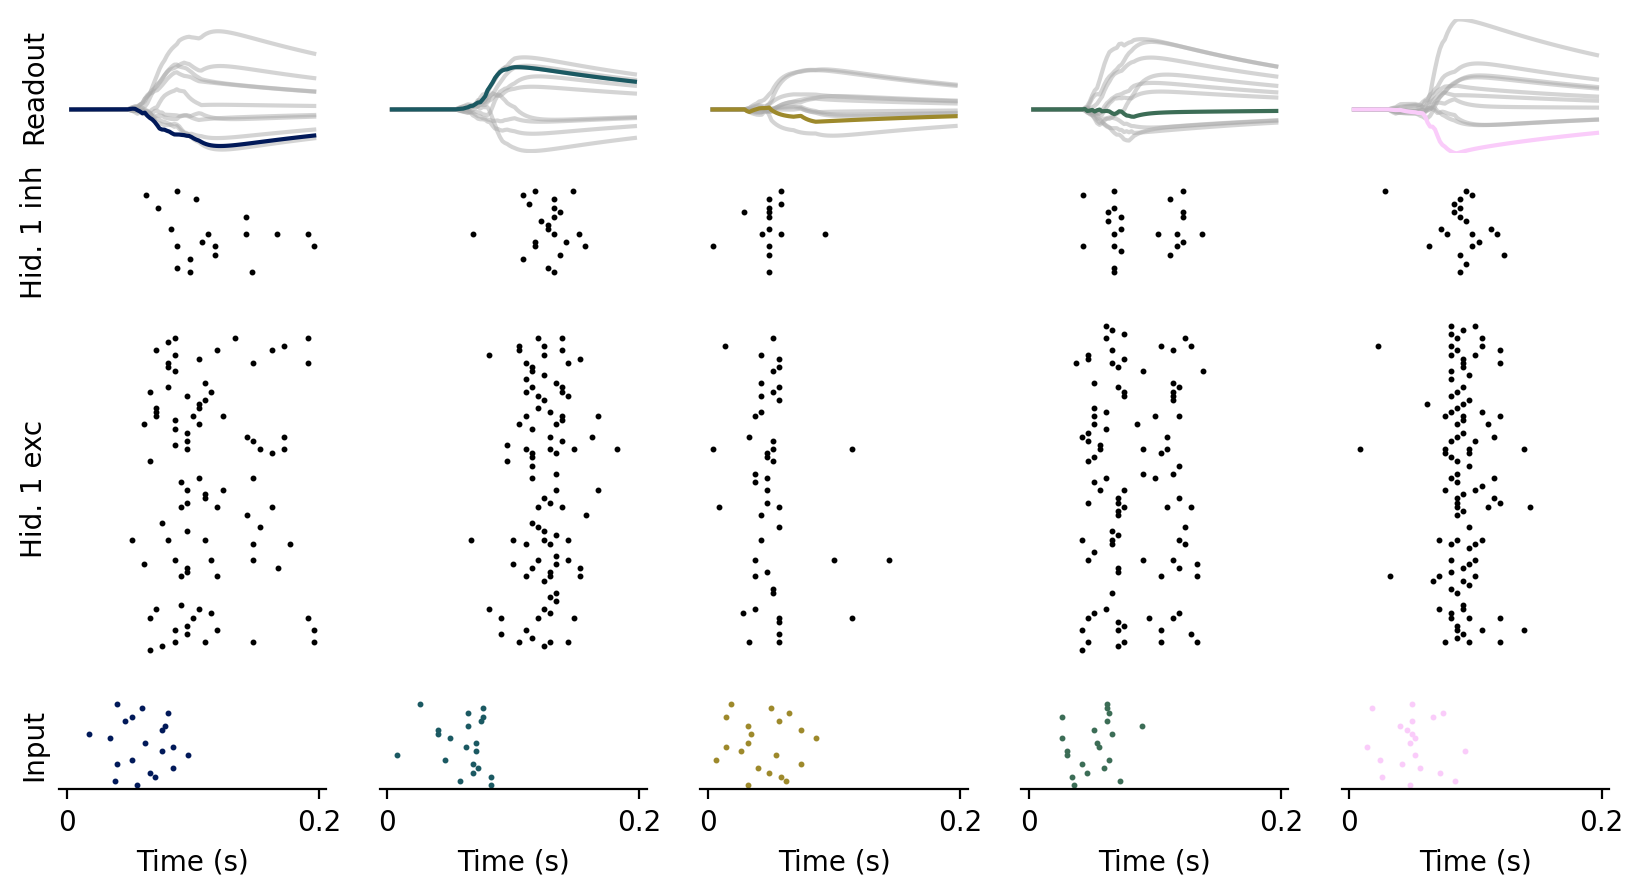

In [71]:
# create nice classification color palette for plotting
colors = cm.batlow(np.linspace(0, 1, nb_classes))

pl = ActivityPlotter(
    model=model,
    data=ds_test,
    nb_samples=5,
    figsize=(10, 5),
    dpi=200,
    plot_label=True,
    label_color="navy",
    batch_size=(batch_size if batch_size < len(ds_test) else 0),
    pal=colors,
)
fig = pl.plot_activity()

In [72]:
# Monitor spike counts before training
results = {}

res = model.monitor(ds_test)
for k, v in res.items():
    results["Pre test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(ds_train)
for k, v in res.items():
    results["Pre train " + k] = v.cpu().numpy()
    print(k, v.shape)

/home/gygajuli/Documents/Projects/stork-1/examples/../../stork-1/stork/monitors.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(num / denom)


syne-Hid. 1 exc torch.Size([1000, 100, 80])
syni-Hid. 1 exc torch.Size([1000, 100, 80])
precise_balance-Hid. 1 exc torch.Size([8000000])
detailed_balance-Hid. 1 exc torch.Size([80000])
tight_balance-Hid. 1 exc torch.Size([8000])
global_balance-Hid. 1 exc torch.Size([80])
syne-Hid. 1 inh torch.Size([1000, 100, 20])
syni-Hid. 1 inh torch.Size([1000, 100, 20])
precise_balance-Hid. 1 inh torch.Size([2000000])
detailed_balance-Hid. 1 inh torch.Size([20000])
tight_balance-Hid. 1 inh torch.Size([2000])
global_balance-Hid. 1 inh torch.Size([20])
syne-Hid. 1 exc torch.Size([8000, 100, 80])
syni-Hid. 1 exc torch.Size([8000, 100, 80])
precise_balance-Hid. 1 exc torch.Size([64000000])
detailed_balance-Hid. 1 exc torch.Size([640000])
tight_balance-Hid. 1 exc torch.Size([64000])
global_balance-Hid. 1 exc torch.Size([640])
syne-Hid. 1 inh torch.Size([8000, 100, 20])
syni-Hid. 1 inh torch.Size([8000, 100, 20])
precise_balance-Hid. 1 inh torch.Size([16000000])
detailed_balance-Hid. 1 inh torch.Size([16

In [73]:
idx = np.random.randint(0, nb_exc_neurons)

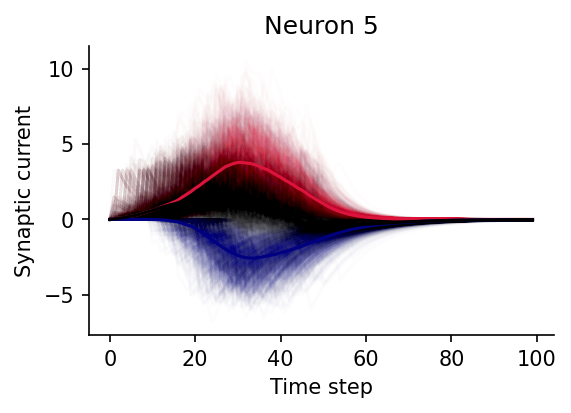

In [74]:
def plot_example_neuron_currents(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=0,
):
    """
    Plot the synaptic currents of a single neuron.
    """
    syne = results[key_exc][:, :, idx_neuron]
    syni = -results[key_inh][:, :, idx_neuron]

    plt.figure(figsize=(4, 2.5), dpi=150)
    fig = plt.plot(syne.T, color="crimson", alpha=0.01, label="Exc.")
    fig = plt.plot(syni.T, color="navy", alpha=0.01, label="Inh.")
    fig = plt.plot(syne.T + syni.T, color="black", alpha=0.01, label="Diff.")

    fig = plt.plot(syne.mean(axis=0), color="crimson", label="Exc.")
    fig = plt.plot(syni.mean(axis=0), color="navy", label="Inh.")
    fig = plt.plot(syne.mean(axis=0) + syni.mean(axis=0), color="black", label="Diff.")
    sns.despine()
    plt.xlabel("Time step")
    plt.ylabel("Synaptic current")
    plt.title(f"Neuron {idx_neuron}")

    return fig


fig = plot_example_neuron_currents(results, idx_neuron=idx)
plt.show()

0.49115524
Precise balance index 0.4911549
0.49115524


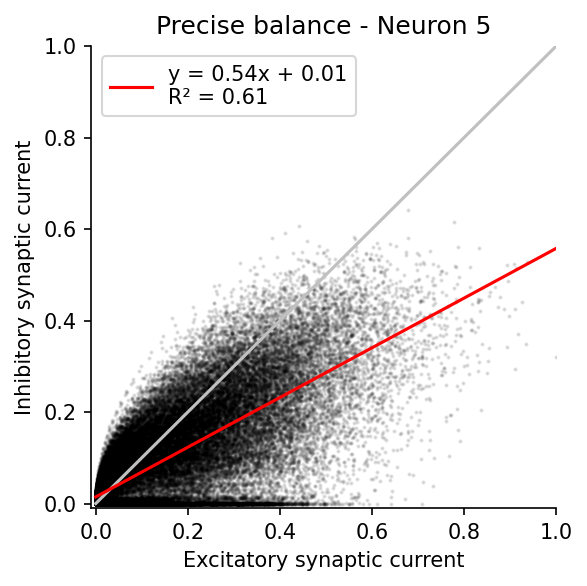

In [75]:
def plot_precise_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=0,
    thr=None,
    scaling=True,
):
    """
    Plot a scatter plot of the excitatory and inhibitory synaptic currents for a single neuron at each time step for each stimulus
    """

    syne = results[key_exc][:, :, idx_neuron].flatten()
    syni = -results[key_inh][:, :, idx_neuron].flatten()

    if scaling:
        scl = np.max([np.max(syne), np.max(-syni)])
        syne = syne / scl
        syni = syni / scl

    if thr is not None:
        mask = (syne > thr) | (syni < -thr)

        syne = syne[mask]
        syni = syni[mask]

    lim = max(np.max(syne), np.max(-syni))

    slope, intercept, r_value, _, _ = linregress(syne, -syni)
    x = np.linspace(0, 100, 100)

    fig = plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(
        syne,
        -syni,
        s=1,
        color="black",
        alpha=0.1,
    )
    plt.plot([0, 100], [0, 100], color="silver")

    # plot linear fit
    plt.plot(
        x,
        slope * x + intercept,
        color="red",
        label=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}",
    )
    plt.legend()

    sns.despine()
    plt.xlabel("Excitatory synaptic current")
    plt.ylabel("Inhibitory synaptic current")
    plt.xlim(-0.01, lim)
    plt.ylim(-0.01, lim)
    plt.title(f"Precise balance - Neuron {idx_neuron}")

    return fig


def balance_idx(syne, syni, eps=1e-8):

    num = (syni + syne) ** 2
    denom = (syne - syni) ** 2 + eps
    return np.mean(num / denom)


def avg_precise_balance(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    thr=None,
    nb_exc_neurons=80,
    scaling=True,
):
    """
    Calculate the precise balance index averaged over all neurons.
    """
    precise_balance = []

    all_syne = results[key_exc]
    all_syni = -results[key_inh]

    if scaling:
        scl = np.max([np.max(all_syne), np.max(-all_syni)])
        all_syne = all_syne / scl
        all_syni = all_syni / scl

    print(balance_idx(all_syne.flatten(), all_syni.flatten()))

    for i in range(nb_exc_neurons):
        syne = all_syne[:, :, i].flatten()
        syni = all_syni[:, :, i].flatten()

        if thr is not None:

            mask = (syne > thr) | (syni < -thr)

            syne = syne[mask]
            syni = syni[mask]

        precise_balance.append(balance_idx(syne, syni))

    return np.mean(precise_balance)


fig = plot_precise_balance_example_neuron(results, idx_neuron=idx)
print(
    "Precise balance index", avg_precise_balance(results, nb_exc_neurons=nb_exc_neurons)
)

print(results["Pre test precise_balance-Hid. 1 exc"].mean())

0.49115524
Precise balance index (large currents) 0.18517748


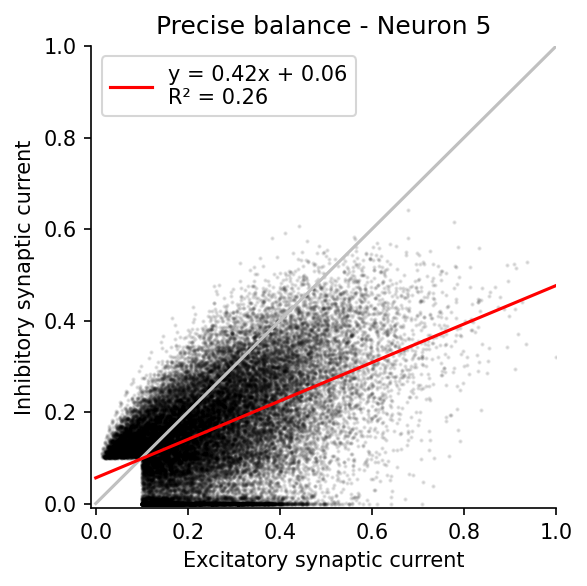

In [76]:
# remove all elements from syne and syni where either syne or syni is smaler than thr

fig = plot_precise_balance_example_neuron(results, idx_neuron=idx, thr=0.1)


print(
    "Precise balance index (large currents)",
    avg_precise_balance(results, nb_exc_neurons=nb_exc_neurons, thr=0.1),
)

0.037927087
Detailed balance: 0.037927084


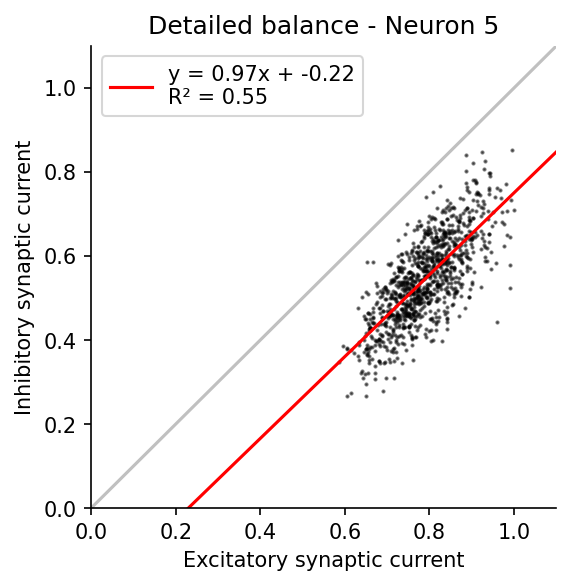

In [77]:
# Detailed balance
def plot_detailed_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=0,
    scaling=True,
):
    """
    Plot a scatter plot of the mean excitatory and inhibitory synaptic currents for a single neuron.
    """

    mean_time_syne = results[key_exc][:, :, idx_neuron].mean(axis=1)
    mean_time_syni = -results[key_inh][:, :, idx_neuron].mean(axis=1)

    if scaling:
        scl = np.max([np.max(mean_time_syne), np.max(-mean_time_syni)])
        mean_time_syne = mean_time_syne / scl
        mean_time_syni = mean_time_syni / scl

    lim = max(np.max(mean_time_syne), np.max(-mean_time_syni)) * 1.1

    slope, intercept, r_value, p_value, std_err = linregress(
        mean_time_syne, -mean_time_syni
    )
    x = np.linspace(0, 100, 100)

    fig = plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(
        mean_time_syne,
        -mean_time_syni,
        s=1,
        color="black",
        alpha=0.5,
    )
    plt.plot([0, 100], [0, 100], color="silver")
    plt.plot(
        x,
        slope * x + intercept,
        color="red",
        label=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}",
    )
    plt.legend()

    sns.despine()
    plt.xlabel("Excitatory synaptic current")
    plt.ylabel("Inhibitory synaptic current")
    plt.title(f"Detailed balance - Neuron {idx_neuron}")

    plt.xlim(0, lim)
    plt.ylim(0, lim)

    return fig


def avg_detailed_balance(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    nb_exc_neurons=80,
    scaling=True,
):
    """
    Calculate the detailed balance index averaged over all neurons.
    """
    detailed_balance = []

    all_syne = results[key_exc]
    all_syni = -results[key_inh]

    if scaling:
        scl = np.max([np.max(all_syne), np.max(-all_syni)])
        all_syne = all_syne / scl
        all_syni = all_syni / scl

    for i in range(nb_exc_neurons):
        syne = all_syne[:, :, i].mean(axis=1)
        syni = all_syni[:, :, i].mean(axis=1)

        detailed_balance.append(balance_idx(syne, syni))

    return np.mean(detailed_balance)


fig = plot_detailed_balance_example_neuron(results, idx_neuron=idx)
print(results["Pre test detailed_balance-Hid. 1 exc"].mean())
print("Detailed balance:", avg_detailed_balance(results, nb_exc_neurons=nb_exc_neurons))

0.49071664
Tight balance index : 0.49071664


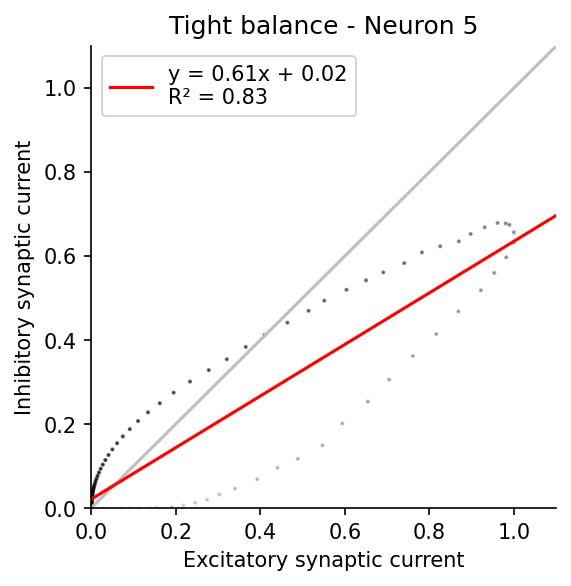

In [78]:
# Tight balance
def plot_tight_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=0,
    scaling=True,
):
    """
    Plot a scatter plot of the mean excitatory and inhibitory synaptic currents for a single neuron.
    """

    mean_stimuli_syne = results[key_exc][:, :, idx_neuron].mean(axis=0)
    mean_stimuli_syni = -results[key_inh][:, :, idx_neuron].mean(axis=0)

    if scaling:
        scl = np.max([np.max(mean_stimuli_syne), np.max(-mean_stimuli_syni)])
        mean_stimuli_syne = mean_stimuli_syne / scl
        mean_stimuli_syni = mean_stimuli_syni / scl

    lim = max(np.max(mean_stimuli_syne), np.max(-mean_stimuli_syni)) * 1.1

    slope, intercept, r_value, p_value, std_err = linregress(
        mean_stimuli_syne, -mean_stimuli_syni
    )
    x = np.linspace(0, 100, 100)

    fig = plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(
        mean_stimuli_syne,
        -mean_stimuli_syni,
        s=1,
        color="black",
        alpha=np.arange(0.01, 1, 1 / len(mean_stimuli_syne)),
    )
    plt.plot([0, 100], [0, 100], color="silver")
    plt.plot(
        x,
        slope * x + intercept,
        color="red",
        label=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}",
    )
    plt.legend()

    sns.despine()
    plt.title(f"Tight balance - Neuron {idx_neuron}")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.xlabel("Excitatory synaptic current")
    plt.ylabel("Inhibitory synaptic current")

    return fig


def avg_tight_balance(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    nb_exc_neurons=80,
    scaling=True,
):
    """
    Calculate the detailed balance index averaged over all neurons.
    """

    all_syne = results[key_exc]
    all_syni = -results[key_inh]

    if scaling:
        scl = np.max([np.max(all_syne), np.max(-all_syni)])
        all_syne = all_syne / scl
        all_syni = all_syni / scl

    tight_balance = []

    for i in range(nb_exc_neurons):
        syne = all_syne[:, :, i].mean(axis=0)
        syni = all_syni[:, :, i].mean(axis=0)

        tight_balance.append(balance_idx(syne, syni))

    return np.mean(tight_balance)


fig = plot_tight_balance_example_neuron(results, idx_neuron=idx)
print(results["Pre test tight_balance-Hid. 1 exc"].mean())
print(
    "Tight balance index :", avg_tight_balance(results, nb_exc_neurons=nb_exc_neurons)
)

0.03133938
Global balance index: 0.031334292


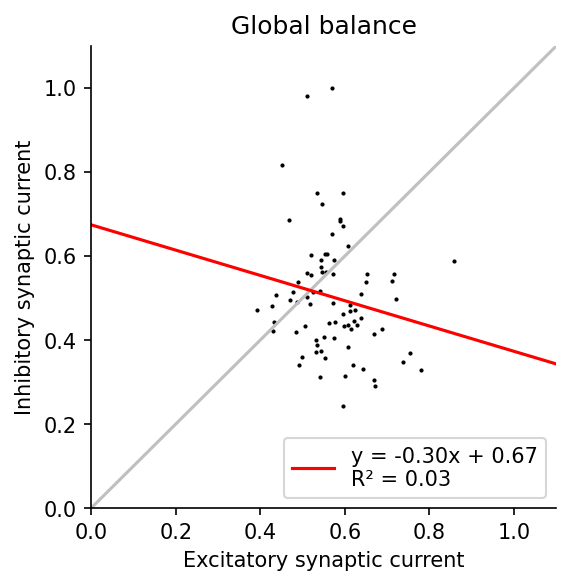

In [79]:
# global balance


def plot_global_balance(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    scaling=True,
):
    """
    Plot a scatter plot of the mean excitatory and inhibitory synaptic currents for all neurons.
    """

    # Calculate mean excitatory and inhibitory synaptic currents across all neurons
    mean_syne = np.mean(results[key_exc], axis=(0, 1))
    mean_syni = np.mean(-results[key_inh], axis=(0, 1))

    if scaling:
        scl = np.max([np.max(mean_syne), np.max(-mean_syni)])
        mean_syne = mean_syne / scl
        mean_syni = mean_syni / scl

    lim = max(np.max(mean_syne), np.max(-mean_syni)) * 1.1

    slope, intercept, r_value, p_value, std_err = linregress(mean_syne, -mean_syni)
    x = np.linspace(0, 100, 100)

    fig = plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(
        mean_syne,
        -mean_syni,
        s=1,
        color="black",
        alpha=1,
    )
    plt.plot([0, 100], [0, 100], color="silver")
    plt.plot(
        x,
        slope * x + intercept,
        color="red",
        label=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}",
    )
    plt.legend()

    sns.despine()
    plt.xlabel("Excitatory synaptic current")
    plt.ylabel("Inhibitory synaptic current")
    plt.title("Global balance")
    plt.xlim(0, lim)
    plt.ylim(0, lim)

    return fig


def avg_global_balance(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    scaling=True,
):
    """
    Calculate the global balance index.
    """
    all_syne = results[key_exc]
    all_syni = -results[key_inh]

    if scaling:
        scl = np.max([np.max(all_syne), np.max(-all_syni)])
        all_syne = all_syne / scl
        all_syni = all_syni / scl

    mean_syne = np.mean(all_syne, axis=(0, 1))
    mean_syni = np.mean(all_syni, axis=(0, 1))

    return balance_idx(mean_syne, mean_syni)


fig = plot_global_balance(results, scaling=True)
print(results["Pre test global_balance-Hid. 1 exc"].mean())
print("Global balance index:", avg_global_balance(results))

## Training

In [ ]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

for k, v in history.items():
    if k in results:
        results[k] = np.concatenate([results[k], v], axis=0)
    else:
        results[k] = np.array(v)

scores = model.evaluate(ds_test).tolist()
print("Scores", scores)
test_dict = model.get_metrics_dict(scores, prefix="test_")

for k, v in test_dict.items():
    if k in results:
        results[k] = np.concatenate([results[k], [v]], axis=0)
    else:
        results[k] = np.array([v])

00  loss = 2.291e+00, reg_loss = 2.813e-07, acc = 13.4% -- val_loss = 2.237e+00, val_reg_loss = 0.000e+00, val_acc = 18.1% t_iter=6.97
01  loss = 2.195e+00, reg_loss = 2.239e-04, acc = 22.9% -- val_loss = 2.163e+00, val_reg_loss = 1.873e-05, val_acc = 22.7% t_iter=6.96
02  loss = 2.107e+00, reg_loss = 1.244e-03, acc = 27.7% -- val_loss = 2.123e+00, val_reg_loss = 0.000e+00, val_acc = 23.9% t_iter=5.40


plotting


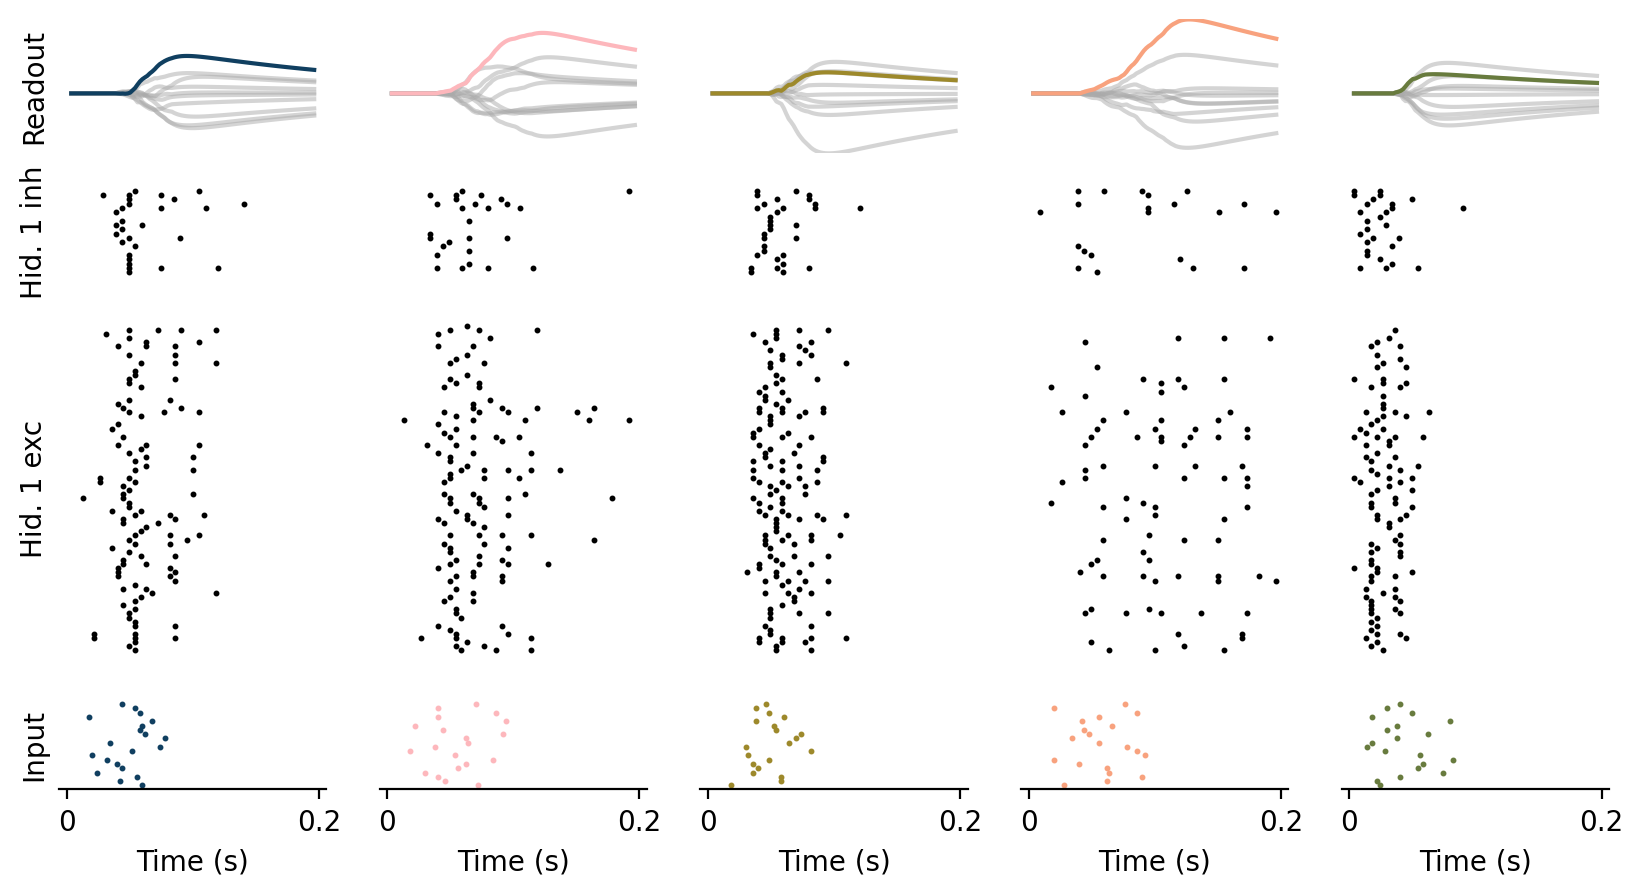

In [ ]:
fig = pl.plot_activity()

In [ ]:
res = model.monitor(ds_test)
for k, v in res.items():
    results["Post test " + k] = v.cpu().numpy()
    print(k, v.shape)

# res = model.monitor(ds_train)
# for k, v in res.items():
#     results["Post train " + k] = v.cpu().numpy()
#     print(k, v.shape)
# print(results)

/home/gygajuli/Documents/Projects/stork-1/examples/../../stork-1/stork/monitors.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(num / denom)


syne-Hid. 1 exc torch.Size([800, 100, 80])
syni-Hid. 1 exc torch.Size([800, 100, 80])
precise_balance-Hid. 1 exc torch.Size([6400000])
detailed_balance-Hid. 1 exc torch.Size([64000])
tight_balance-Hid. 1 exc torch.Size([8000])
global_balance-Hid. 1 exc torch.Size([80])
syne-Hid. 1 inh torch.Size([800, 100, 20])
syni-Hid. 1 inh torch.Size([800, 100, 20])
precise_balance-Hid. 1 inh torch.Size([1600000])
detailed_balance-Hid. 1 inh torch.Size([16000])
tight_balance-Hid. 1 inh torch.Size([2000])
global_balance-Hid. 1 inh torch.Size([20])


## Test

In [ ]:
scores = model.evaluate(ds_test).tolist()

#### Visualize performance

['loss', 'reg_loss', 'acc']
Test acc: 0.43375


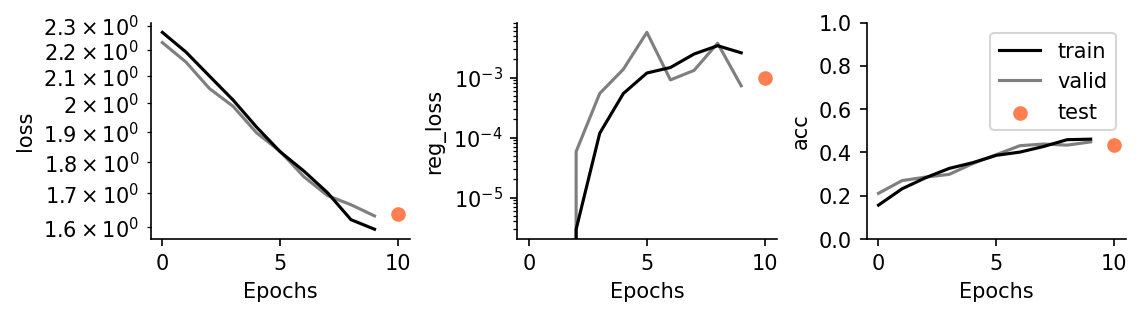

In [ ]:
names = [
    k
    for k in results.keys()
    if not ("val" in k or "test" in k or "Monitor" in k or "Pre" in k or "Post" in k)
]
print(names)

fig = plot_training(
    results,
    nb_epochs=nb_epochs,
    epoch_chunks=1,  # cfg.training.epoch_chunks,
    names=names,
)

print("Test acc:", results["test_acc"][-1])

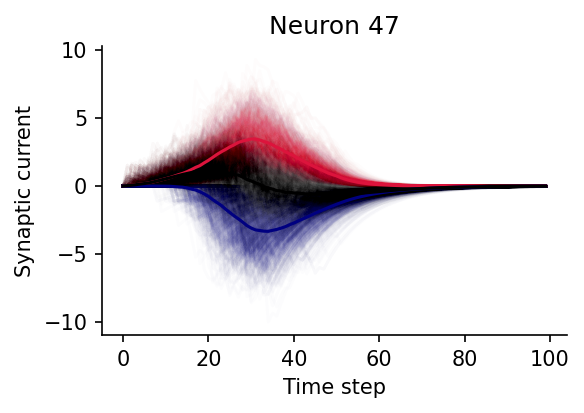

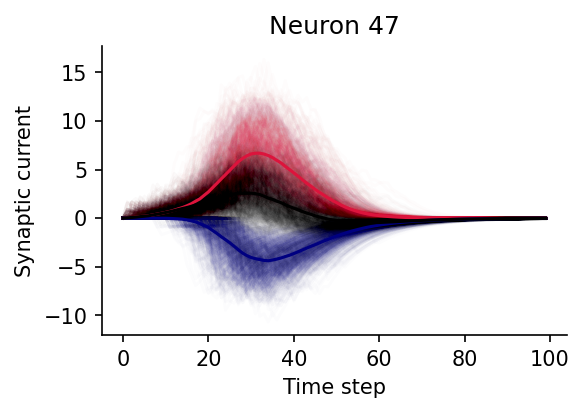

In [ ]:
fig = plot_example_neuron_currents(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=idx,
)
plt.show()
fig = plot_example_neuron_currents(
    results,
    key_exc="Post test syne-Hid. 1 exc",
    key_inh="Post test syni-Hid. 1 exc",
    idx_neuron=idx,
)

0.5193969
0.5193969
Precise balance before 0.5193969
0.5058403
0.5058403
Precise balance after 0.50584006


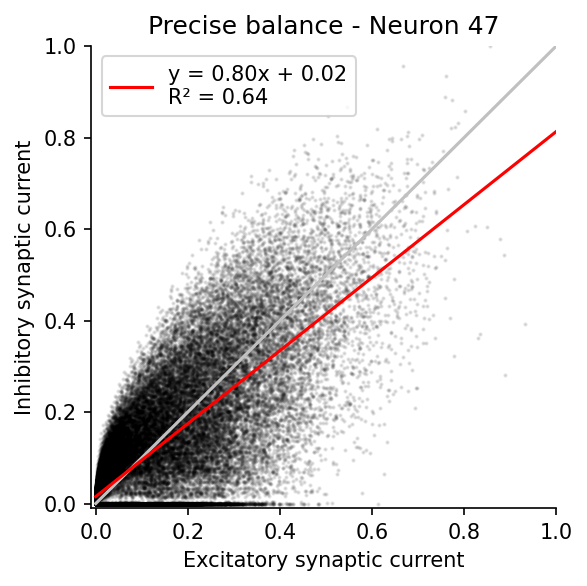

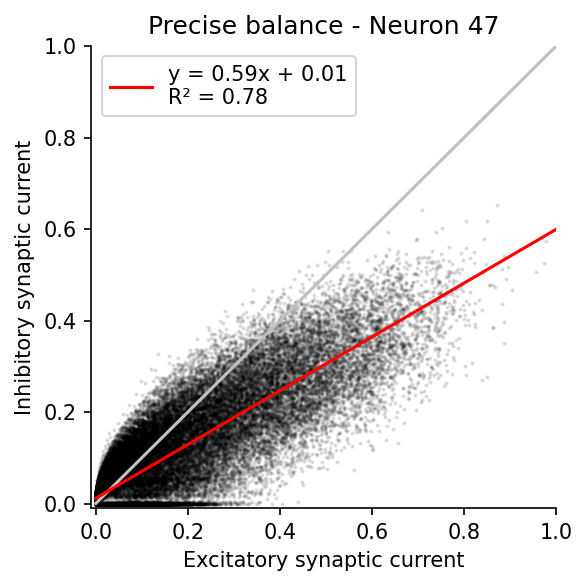

In [ ]:
print(results["Pre test precise_balance-Hid. 1 exc"].mean())
print(
    "Precise balance before",
    avg_precise_balance(
        results,
        key_exc="Pre test syne-Hid. 1 exc",
        key_inh="Pre test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
    ),
)
print(results["Post test precise_balance-Hid. 1 exc"].mean())
print(
    "Precise balance after",
    avg_precise_balance(
        results,
        key_exc="Post test syne-Hid. 1 exc",
        key_inh="Post test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
    ),
)


fig = plot_precise_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=idx,
)
plt.show()
fig = plot_precise_balance_example_neuron(
    results,
    key_exc="Post test syne-Hid. 1 exc",
    key_inh="Post test syni-Hid. 1 exc",
    idx_neuron=idx,
)

0.5193969
Precise balance before 0.19273368
0.5058403
Precise balance after 0.15970722


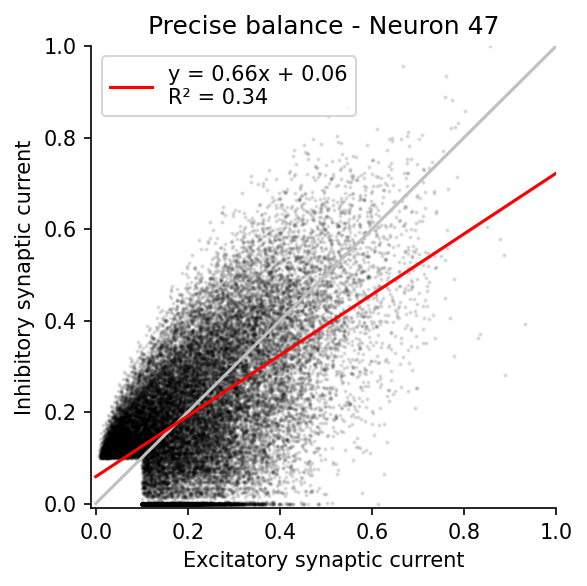

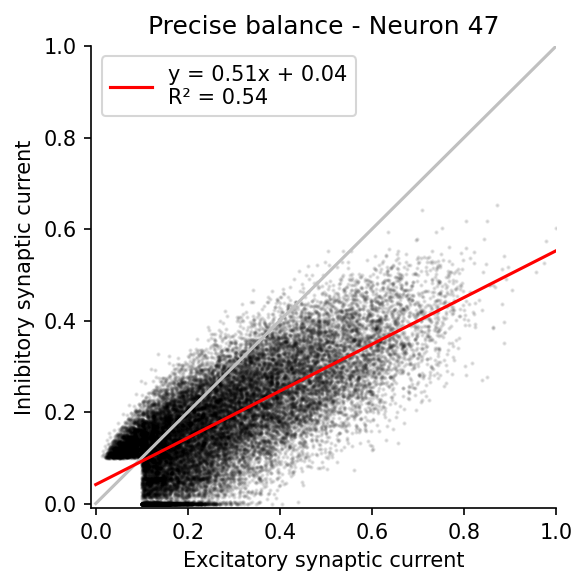

In [ ]:
print(
    "Precise balance before",
    avg_precise_balance(
        results,
        key_exc="Pre test syne-Hid. 1 exc",
        key_inh="Pre test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
        thr=0.1,
    ),
)
print(
    "Precise balance after",
    avg_precise_balance(
        results,
        key_exc="Post test syne-Hid. 1 exc",
        key_inh="Post test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
        thr=0.1,
    ),
)


fig = plot_precise_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=idx,
    thr=0.1,
)
plt.show()
fig = plot_precise_balance_example_neuron(
    results,
    key_exc="Post test syne-Hid. 1 exc",
    key_inh="Post test syni-Hid. 1 exc",
    idx_neuron=idx,
    thr=0.1,
)

0.029975563
Detailed balance before: 0.029975567
0.024603264
Detailed balance after: 0.024603266


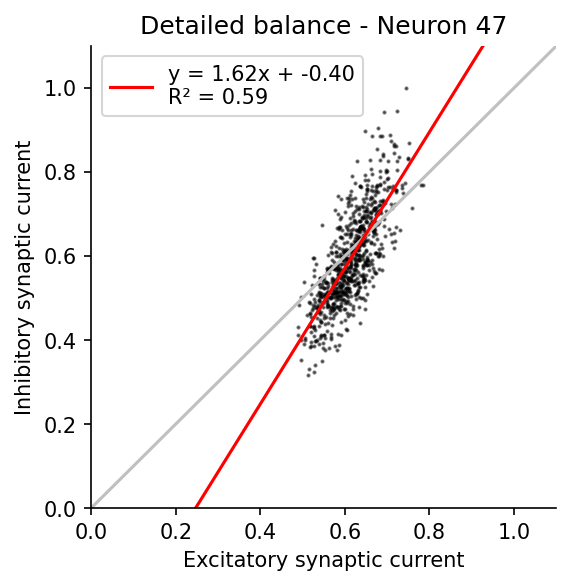

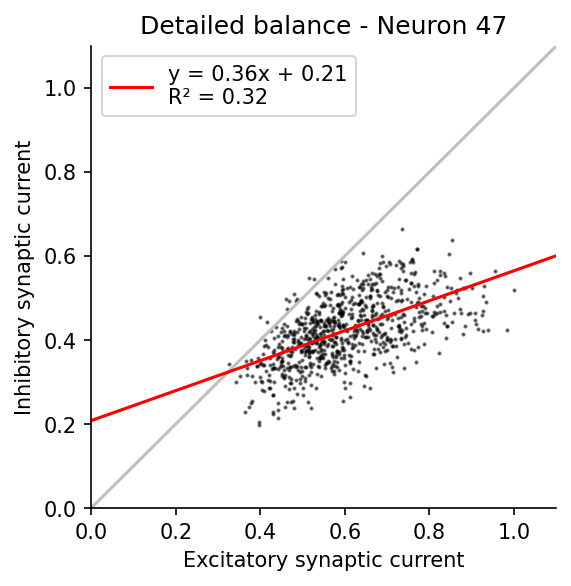

In [ ]:
print(results["Pre test detailed_balance-Hid. 1 exc"].mean())
print(
    "Detailed balance before:",
    avg_detailed_balance(
        results,
        key_exc="Pre test syne-Hid. 1 exc",
        key_inh="Pre test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
    ),
)
print(results["Post test detailed_balance-Hid. 1 exc"].mean())
print(
    "Detailed balance after:",
    avg_detailed_balance(
        results,
        key_exc="Post test syne-Hid. 1 exc",
        key_inh="Post test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
    ),
)

fig = plot_detailed_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=idx,
)

plt.show()
fig = plot_detailed_balance_example_neuron(
    results,
    key_exc="Post test syne-Hid. 1 exc",
    key_inh="Post test syni-Hid. 1 exc",
    idx_neuron=idx,
)

0.5127858
Tight balance before: 0.5127858
0.49567595
Tight balance after: 0.49567598


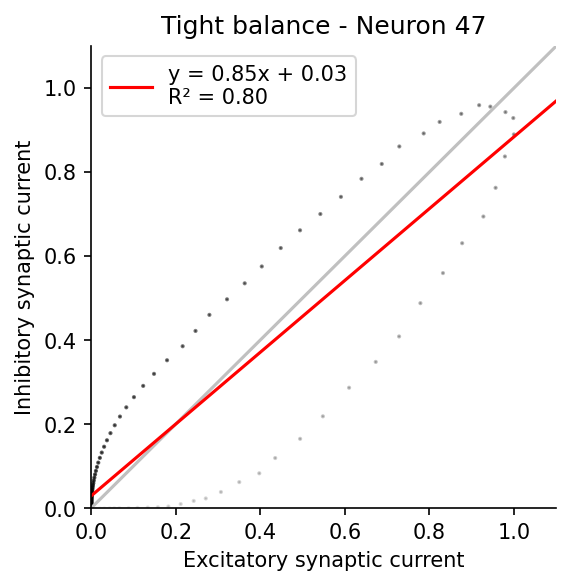

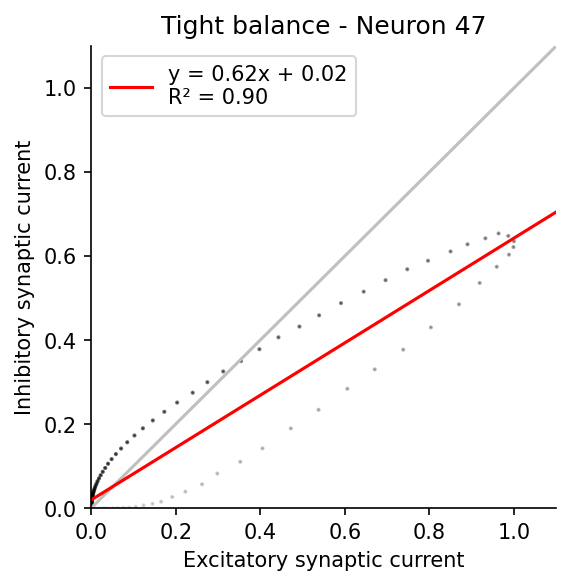

In [ ]:
print(results["Pre test tight_balance-Hid. 1 exc"].mean())
print(
    "Tight balance before:",
    avg_tight_balance(
        results,
        key_exc="Pre test syne-Hid. 1 exc",
        key_inh="Pre test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
    ),
)
print(results["Post test tight_balance-Hid. 1 exc"].mean())
print(
    "Tight balance after:",
    avg_tight_balance(
        results,
        key_exc="Post test syne-Hid. 1 exc",
        key_inh="Post test syni-Hid. 1 exc",
        nb_exc_neurons=nb_exc_neurons,
    ),
)

fig = plot_tight_balance_example_neuron(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
    idx_neuron=idx,
)
plt.show()
fig = plot_tight_balance_example_neuron(
    results,
    key_exc="Post test syne-Hid. 1 exc",
    key_inh="Post test syni-Hid. 1 exc",
    idx_neuron=idx,
)

0.023107603
Global balance before: 0.023106752
0.014558589
Global balance after: 0.0145576475


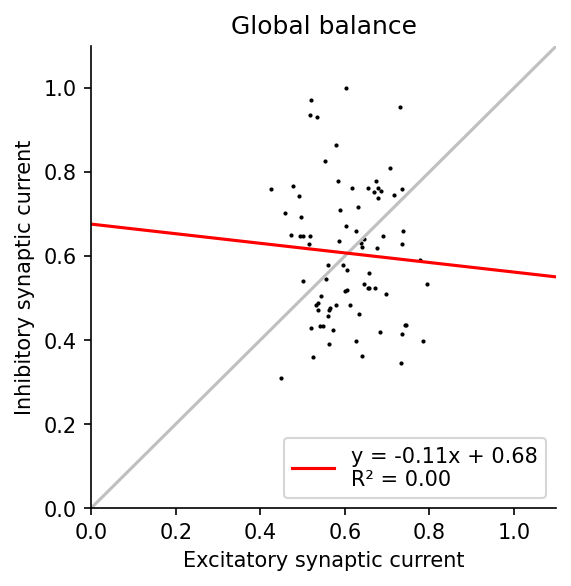

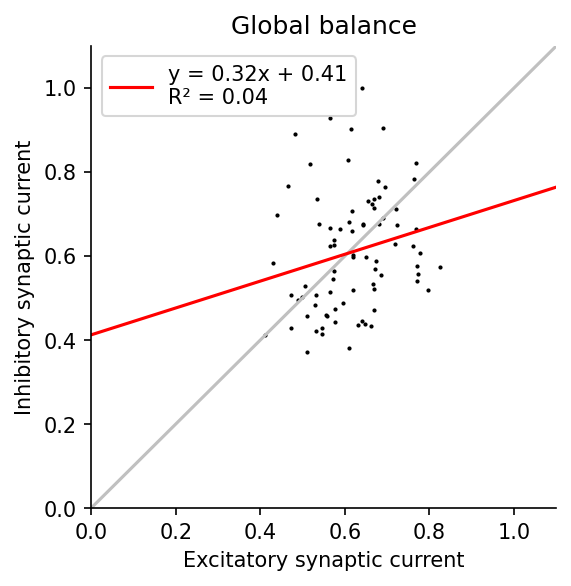

In [ ]:
print(results["Pre test global_balance-Hid. 1 exc"].mean())
print(
    "Global balance before:",
    avg_global_balance(
        results,
        key_exc="Pre test syne-Hid. 1 exc",
        key_inh="Pre test syni-Hid. 1 exc",
    ),
)
print(results["Post test global_balance-Hid. 1 exc"].mean())
print(
    "Global balance after:",
    avg_global_balance(
        results,
        key_exc="Post test syne-Hid. 1 exc",
        key_inh="Post test syni-Hid. 1 exc",
    ),
)

fig = plot_global_balance(
    results,
    key_exc="Pre test syne-Hid. 1 exc",
    key_inh="Pre test syni-Hid. 1 exc",
)
plt.show()
fig = plot_global_balance(
    results,
    key_exc="Post test syne-Hid. 1 exc",
    key_inh="Post test syni-Hid. 1 exc",
)